In [1]:
import math
import sys
import matplotlib.pyplot as plt

import boto3
import numpy as np

sys.path.append('../')
sys.path.append('../../')
from run_utils import get_env_dataset, run_env_experiment, plot_ratings_mses
from run_utils import s3_experiment_dir_name, plot_ratings_mses_s3, s3_load_trial
from reclab.environments import Topics, LatentFactorBehavior
from env_defaults import *
from reclab.recommenders import TopPop


/home/ec2-user/recsys-eval/experiments/run_utils.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

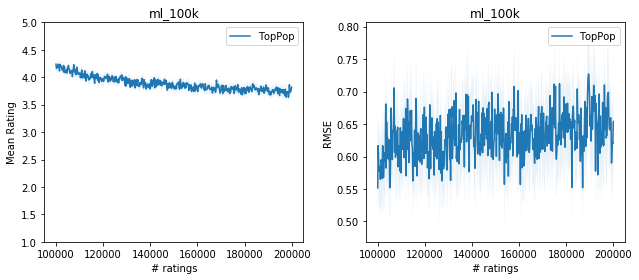

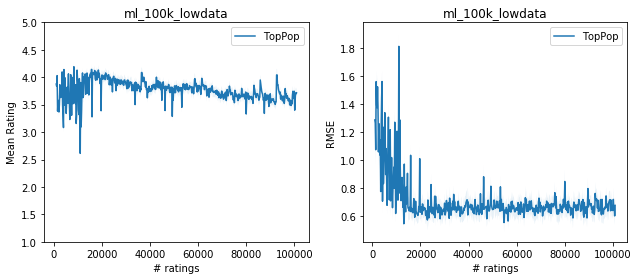

In [6]:
# S3 storage parameters
bucket_name = 'recsys-eval'
data_dir = 'master'

env_names = ['topics_static', 'topics_dynamic', 'latent_static', 'latent_dynamic'] + \
            ['topics_static_small', 'topics_dynamic_small', 'latent_static_small', 'latent_dynamic_small']
env_names = ['ml_100k', 'ml_100k_lowdata'] # 'latent_static', 'latent_dynamic', 
recommender_names = ['TopPop'] # ['PerfectRec', 'TopPop', 'RandomRec'] #, 'EASE']

for env_name in env_names:

    if env_name == 'topics_static':
        ENV_PARAMS = TOPICS_STATIC
    elif env_name == 'topics_dynamic':
        ENV_PARAMS = TOPICS_DYNAMIC
    elif env_name == 'latent_static':
        ENV_PARAMS = LATENT_STATIC
    elif env_name == 'latent_dynamic':
        ENV_PARAMS = LATENT_DYNAMIC
    elif env_name == 'topics_static_small':
        ENV_PARAMS = TOPICS_STATIC_SMALL
    elif env_name == 'topics_dynamic_small':
        ENV_PARAMS = TOPICS_DYNAMIC_SMALL
    elif env_name == 'latent_static_small':
        ENV_PARAMS = LATENT_STATIC_SMALL
    elif env_name == 'latent_dynamic_small':
        ENV_PARAMS = LATENT_DYNAMIC_SMALL
    elif env_name == 'ml_100k':
        ENV_PARAMS = ML_100K
    elif env_name == 'ml_100k_lowdata':
        ENV_PARAMS = ML_100K_LOWDATA
    else:
        assert False, "environment not implemented!"


    # Experiment setup.
    n_trials = 1
    trial_seeds = [i for i in range(n_trials)]
    num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings']
    len_trial = get_len_trial(ENV_PARAMS)
    num_users, _ = get_num_users_items(ENV_PARAMS)

    environment_name = ENV_PARAMS['name']
    env_name = ENV_PARAMS['name']

    plot_ratings_mses_s3(recommender_names,
                         len_trial,
                         bucket_name,
                         data_dir,
                         env_name,
                         trial_seeds,
                         plot_dense=False,
                         num_users=num_users,
                         num_init_ratings=num_init_ratings,
                         rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                         threshold=10,
                         title=[env_name, env_name])
    

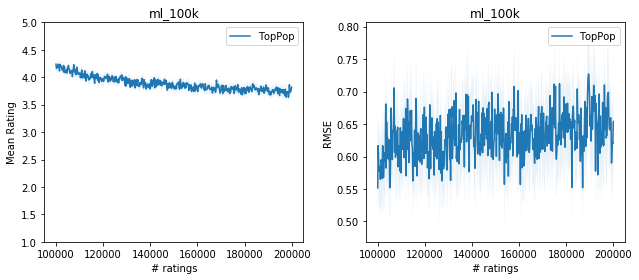

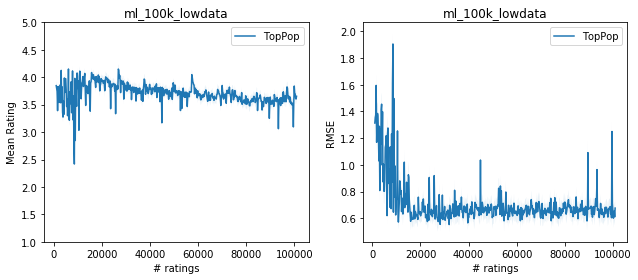

In [5]:
# Below is a model trained with biases (above the model is trained without biases)

In [3]:
num_init_ratings

1000

# Targetted rating investigation

In [36]:
# S3 storage parameters
bucket_name = 'recsys-eval'
data_dir = 'master'

env_name = 'topics_dynamic'
rec_name = 'TopPop'

seed = 0

bucket = boto3.resource('s3').Bucket(bucket_name)
dir_name = s3_experiment_dir_name(data_dir, env_name, rec_name, seed)

res = s3_load_trial(bucket, dir_name, load_dense=True)
rec_hyperparameters, ratings, predictions, dense_ratings, dense_predictions, env_snapshots = res

In [43]:
predictions

array([[3.60831561, 3.60831561, 3.54920085, ..., 3.60831561, 3.60831561,
        3.60831561],
       [3.55393525, 3.55393525, 3.55393525, ..., 3.55393525, 3.55393525,
        3.54988943],
       [3.61663168, 3.61663168, 3.61663168, ..., 3.61663168, 3.61663168,
        3.61663168],
       ...,
       [4.33852062, 3.5442598 , 3.5442598 , ..., 4.33852062, 3.5442598 ,
        4.33852062],
       [3.5869802 , 4.35562549, 3.16229621, ..., 3.5869802 , 4.35562549,
        4.35562549],
       [3.59527462, 3.13271048, 3.59527462, ..., 3.59527462, 3.13271048,
        3.13271048]])

In [42]:
ratings.shape

(500, 200)

In [40]:
env_snapshots[100]._user_preferences

array([[3.39962308, 4.75928017, 3.0360391 , ..., 0.8622031 , 4.60754367,
        4.12411709],
       [4.42783852, 4.86531393, 4.60134838, ..., 3.90484415, 3.3493675 ,
        3.05689221],
       [4.81874039, 3.61465705, 2.21420617, ..., 1.67216156, 1.01210314,
        3.57665274],
       ...,
       [3.48814065, 4.88973791, 0.5611595 , ..., 4.5510338 , 0.75632668,
        2.59087602],
       [3.72606523, 2.29837399, 3.79930549, ..., 0.24544956, 4.46444066,
        1.51739586],
       [2.25980778, 4.66246184, 4.78869622, ..., 2.59515674, 0.65962743,
        4.21208428]])

In [6]:
dense_predictions.shape

(531, 1586126)

In [18]:
ratings = ratings[np.newaxis, np.newaxis, :, :]
predictions = predictions[np.newaxis, np.newaxis, :, :]
dense_ratings = dense_ratings[np.newaxis, np.newaxis, :, :]
dense_predictions = dense_predictions[np.newaxis, np.newaxis, :, :]

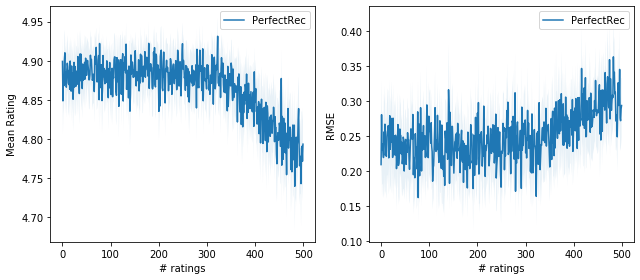

In [28]:
plot_ratings_mses(ratings,
                      np.clip(predictions, 1, 5),
                      [rec_name])

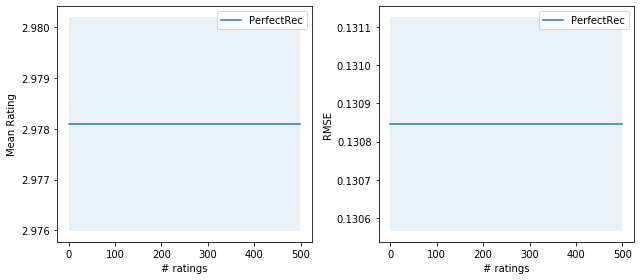

In [21]:
plot_ratings_mses(dense_ratings,
                      dense_predictions,
                      [rec_name])

(array([89524500., 87268000., 84615500., 83790000., 86334000., 85959500.,
        80444500., 82568000., 83908000., 85588000.]),
 array([0.50036225, 1.000315  , 1.50026775, 2.0002205 , 2.50017325,
        3.000126  , 3.50007875, 4.00003151, 4.49998426, 4.99993701,
        5.49988976]),
 <a list of 10 Patch objects>)

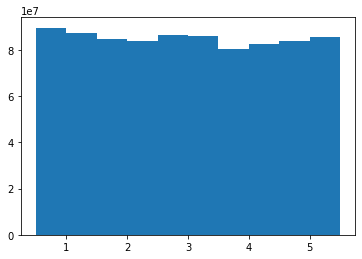

In [23]:
plt.figure()
plt.hist(dense_predictions.flatten())

(array([   58.,   176.,   461.,   793.,  2404.,  3884.,  7128., 14782.,
        26378., 43936.]),
 array([3.7026507 , 3.88237461, 4.06209852, 4.24182242, 4.42154633,
        4.60127023, 4.78099414, 4.96071804, 5.14044195, 5.32016585,
        5.49988976]),
 <a list of 10 Patch objects>)

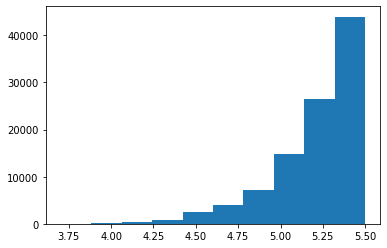

In [24]:
plt.figure()
plt.hist(predictions.flatten())

(array([1.0000e+00, 6.0000e+00, 1.5000e+01, 7.4000e+01, 2.9200e+02,
        8.2400e+02, 2.2500e+03, 5.1770e+03, 9.8550e+03, 8.1506e+04]),
 array([2.18677833, 2.46810049, 2.74942266, 3.03074483, 3.312067  ,
        3.59338916, 3.87471133, 4.1560335 , 4.43735567, 4.71867783,
        5.        ]),
 <a list of 10 Patch objects>)

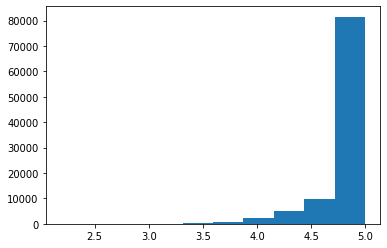

In [25]:
plt.figure()
plt.hist(ratings.flatten())